### Проект оценки влияния условий жизни учащихся на успеваемость по математике.

С помощью собранных данных о семье, качестве жизни, учебной нагрузке учащихся небходимо проверить связь этих условий жизни с результатами госэкзаменов по математике, чтобы на ранней стадии выявлять находящихся в группе риска студентов со слабой успеваемостью.

In [1]:
%load_ext autoreload
%aimport edatools.clean
%autoreload 1

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

pd.options.display.max_columns = None

#### Дано

In [3]:
sample = pd.read_csv('stud_math.csv').convert_dtypes()
sample.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,<NA>,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,-6,yes,<NA>,no,4,3,4,3,6,30
1,GP,F,17,U,GT3,<NA>,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,-6,yes,yes,no,5,3,3,3,4,30
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,<NA>,no,yes,-6,yes,yes,<NA>,4,3,2,3,10,50
3,GP,F,15,U,GT3,T,4,2,health,<NA>,home,mother,1,3,0,no,yes,yes,yes,yes,-9,yes,yes,yes,3,2,2,5,2,75
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,-6,yes,no,no,4,3,2,5,4,50


#### Метаданные

Мы знаем структуру датасета и набор значений некоторых полей, поэтому выполним сначала простые преобразования.

Переименуем колонки.

In [4]:
columns = {
    'famsize'            : 'family_size',
    'Pstatus'            : 'parental_cohabitation',
    'Medu'               : 'mother_education',
    'Fedu'               : 'father_education',
    'Mjob'               : 'mother_job',
    'Fjob'               : 'father_job',
    'reason'             : 'choice_reason',
    'traveltime'         : 'travel_time',
    'studytime'          : 'extra_study',
    'schoolsup'          : 'school_support',
    'famsup'             : 'family_support',
    'studytime, granular': 'extra_study_granular',
    'famrel'             : 'family_relations',
    'goout'              : 'friends_time',
}
sample.rename(columns=columns, inplace=True)

И проверим соответствие данных наборам значений известных типов.

In [5]:
from edatools.clean import check_anomalies

In [6]:
# структура для проверки на ошибки или аномальные значения
check_actions = {
    'sex': {
        'restrict': ('F', 'M')
    },
    'address': {
        'restrict': ('U', 'R')
    },
    'family_size': {
        'restrict': ('LE3', 'GT3')
    },
    'parental_cohabitation': {
        'restrict': ('T', 'A')
    },
    'mother_education': {
        'restrict': (0, 1, 2, 3, 4)
    },
    'father_education': {
        'restrict': (0, 1, 2, 3, 4)
    },
    'mother_job': {
        'restrict': ('teacher', 'health', 'services', 'at_home', 'other')
    },
    'father_job': {
        'restrict': ('teacher', 'health', 'services', 'at_home', 'other')
    },
    'choice_reason': {
        'restrict': ('home', 'reputation', 'course', 'other')
    },
    'guardian': {
        'restrict': ('mother', 'father', 'other')
    },
    'travel_time': {
        'restrict': (1, 2, 3, 4)
    },
    'extra_study': {
        'restrict': (1, 2, 3, 4)
    },
    'failures': {
        'restrict': (0, 1, 2, 3)
    },
    'school_support': {
        'restrict': ('yes', 'no')
    },
    'family_support': {
        'restrict': ('yes', 'no')
    },
    'paid': {
        'restrict': ('yes', 'no')
    },
    'activities': {
        'restrict': ('yes', 'no')
    },
    'nursery': {
        'restrict': ('yes', 'no')
    },
    'higher': {
        'restrict': ('yes', 'no')
    },
    'internet': {
        'restrict': ('yes', 'no')
    },
    'romantic': {
        'restrict': ('yes', 'no')
    },
    'family_relations': {
        'restrict': (1, 2, 3, 4, 5)
    },
    'freetime': {
        'restrict': (1, 2, 3, 4, 5)
    },
    'friends_time': {
        'restrict': (1, 2, 3, 4, 5)
    },
    'health': {
        'restrict': (1, 2, 3, 4, 5)
    }
}

In [7]:
check_anomalies(sample, check_actions)

{'father_education': {40: 1}, 'family_relations': {-1: 1}}

Можно предположить, что эти аномалии — опечатки (значений `4` и `1` соответственно). Исправим их.

In [8]:
sample.father_education.replace(40, 4, inplace=True)
sample.family_relations.replace(-1, 1, inplace=True)

#### Очистка

Изучим оставшиеся поля

In [9]:
sample.loc[:, [name for name in sample.columns if name not in check_actions]].dtypes

school                  string
age                      Int64
extra_study_granular     Int64
absences                 Int64
score                    Int64
dtype: object

In [10]:
display(sample.school.value_counts(dropna=False))

GP    349
MS     46
Name: school, dtype: Int64

Поле с аббревиатурами школ выглядит корректно заполненным. Рассмотрим остальные числовые поля в части распределения и выбросов.

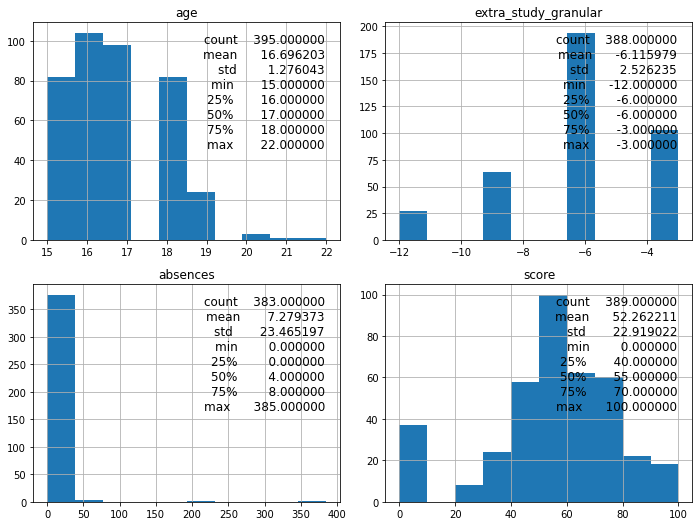

In [11]:
columns = ('age', 'extra_study_granular', 'absences', 'score')

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(6.4*1.5, 4.8*1.5),
                        constrained_layout=True)
for i in range(len(columns)):
    ax = sample[columns[i]].hist(ax=axs[i//2, i%2])
    ax.set_title(columns[i])
    ax.annotate(sample[columns[i]].describe().to_string(), (0.95, 0.95),
                xycoords='axes fraction', va='top', ha='right', size='large')

Данные о возрасте опрошенных укладываются в изучаемый диапазон (от 15 до 22 лет), однако оценим корреляцию возраста со здоровьем и результатами экзаменов, чтобы проверить предположение о том, что это неуспевающие ученики, и возраст заполнен корректно.

In [12]:
df = sample[['age', 'health', 'score']].astype('float64')

print('Корреляция возраста со здоровьем и экзаменационной оценкой')
display(df.corr().loc[['age'], :])

print('Статистические показатели "взрослых" учеников в сравнении со всей выборкой')
adults = df.loc[df.age > df.age.quantile(.75)].describe()
df.describe().join(adults, lsuffix='_all', rsuffix='_adults')

Корреляция возраста со здоровьем и экзаменационной оценкой


,age,health,score
age,1.0,-0.065946,-0.155726


Статистические показатели "взрослых" учеников в сравнении со всей выборкой


,age_all,health_all,score_all,age_adults,health_adults,score_adults
count,395.000000,380.000000,389.000000,29.000000,28.000000,26.000000
mean,16.696203,3.531579,52.262211,19.275862,3.428571,43.461538
std,1.276043,1.396019,22.919022,0.701862,1.345185,24.850321
min,15.000000,1.000000,0.000000,19.000000,1.000000,0.000000
25%,16.000000,3.000000,40.000000,19.000000,3.000000,40.000000
50%,17.000000,4.000000,55.000000,19.000000,3.000000,45.000000
75%,18.000000,5.000000,70.000000,19.000000,5.000000,58.750000
max,22.000000,5.000000,100.000000,22.000000,5.000000,90.000000


Действительно, успеваемость учеников старше 19 лет удовлетворительна. Интересно, что есть отрицательная корреляция между возрастом и экзаменационной оценкой во **всей** выборке.

Мы полагаем, что отдельные наблюдения в выборке — это результаты учебного года. В данных об отсутствиях есть явные выбросы превышающие количество учебных дней (их оценим как 260 будних дней в году минус 10 недель летних каникул, что есть _примерно_ 200 дн.). Обнулим эти выбросы и взглянем еще раз на распределение.

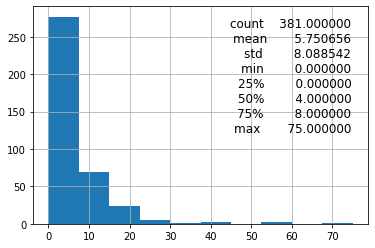

In [13]:
sample.absences = sample.absences.mask(sample.absences > 200)

ax = sample.absences.hist();
ax.annotate(sample.absences.describe().to_string(), (0.95, 0.95),
            xycoords='axes fraction', va='top', ha='right', size='large');

Теперь распределение пропущенных значений выглядит правдоподобно.

Экзаменационная оценка распределена нормально, но есть выбивающиеся из этого распределения околонулевые значения. Может ли это означать несданный экзамен по причине пропуска?

In [14]:
sample.loc[sample.score < 20, ['score', 'absences']].describe()

,score,absences
count,37.0,36.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


Наше наивное предположение не подтвердилось, и связи оценки с количеством пропущенных занятий нет. Оставим такие значения как есть.